## MNIST dataset processed with a Visual Transformer (not good results for small datasets)

In [4]:
import sys
sys.path.append('../')  # to be able to import the MNIST model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Reset the random seed to get deterministic results 

In [7]:
torch.manual_seed(0)
np.random.seed(0)

In [8]:
BATCH_SIZE = 64
LR = 5e-5
NUM_EPOCHES = 25

## Preprocessing

In [9]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std)
])

In [10]:
train_data = datasets.MNIST('../data/', download=True, train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = datasets.MNIST('../data/', download=True, train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
def draw(dataset, idx: int) -> None:
    plt.title(f'label: {dataset.targets[idx].item()}')
    plt.imshow(dataset.data[idx].int())

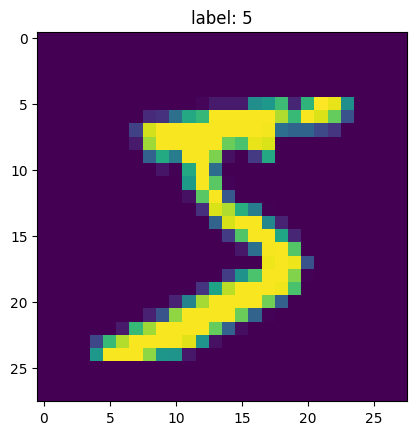

In [12]:
draw(train_data, 0)

## Model

In [13]:
from models import MNISTViTModel

In [14]:
model = MNISTViTModel().to(device)
model

MNISTViTModel(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.2, inplace=False)
            (to_qkv): Linear(in_features=256, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
              (1): Dropout(p=0.2, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=256, out_features

In [15]:
for batch, labels in train_dataloader:
    batch = batch.to(device)
    labels = labels.to(device)
    
    print(f'Batch Image Dimensions: {batch.size()}')
    print(f'Labels Dimensions: {labels.size()}')
    print('-'*100)
    
    out = model(batch)
    
    print(f'Output Dimensions: {out.size()}')
    print(f'Out: {out[0]}')
    break

Batch Image Dimensions: torch.Size([64, 1, 28, 28])
Labels Dimensions: torch.Size([64])
----------------------------------------------------------------------------------------------------
Output Dimensions: torch.Size([64, 10])
Out: tensor([0.5655, 0.3004, 0.7868, 0.7438, 0.8608, 0.7051, 1.3010, 0.5096, 0.3076,
        0.2308], device='cuda:0', grad_fn=<SelectBackward0>)


In [16]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

In [17]:
loss_hist = {}
loss_hist['train accuracy'] = []
loss_hist['train loss'] = []

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(train_dataloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
            
        epoch_train_loss += loss.item()
    
    loss_hist['train loss'].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist['train accuracy'].append(accuracy)
    
    print('-------------------------------------------------')
    print('Epoch: {} Train mean loss: {:.8f}'.format(epoch, epoch_train_loss))
    print('       Train Accuracy%: ', accuracy, '==', total_correct, '/', total)
    print('-------------------------------------------------')

-------------------------------------------------
Epoch: 1 Train mean loss: -10241.10195428
       Train Accuracy%:  72.93666666666667 == 43762 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: -23396.11166382
       Train Accuracy%:  91.945 == 55167 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: -38637.12664604
       Train Accuracy%:  93.53166666666667 == 56119 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: -56368.68750000
       Train Accuracy%:  94.62 == 56772 / 60000
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: -76115.01230621
       Train Accuracy%:  95.03833333333333 == 57023 / 60000
-------------------------------------------------
-------------

## Test

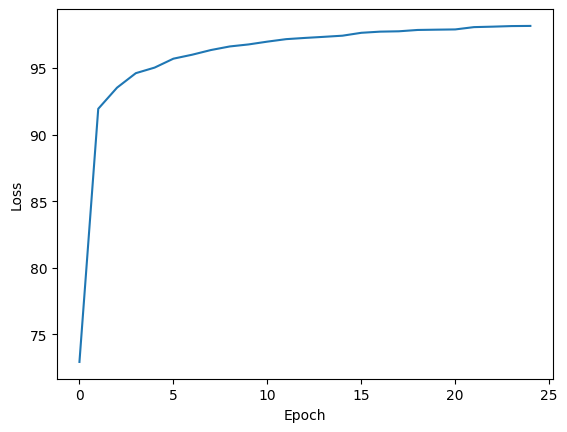

In [21]:
plt.plot(loss_hist['train accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

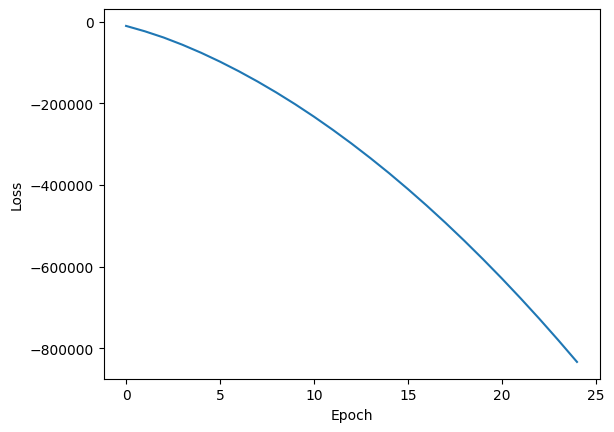

In [22]:
plt.plot(loss_hist['train loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
with torch.no_grad():
    model.eval()
    
    y_true_test = []
    y_pred_test = []
    
    for batch_idx, (img, labels) in enumerate(test_dataloader):
        img = img.to(device)
        labels = labels.to(device)
    
        preds = model(img)
        
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
        
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print('Test Accuracy%: ', accuracy, '==', total_correct, '/', total)

NameError: name 'label' is not defined

In [ ]:
def eval_image(model: nn.Module, X: torch.Tensor):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        pred = model(X)
        return pred[0].argmax(0).item()


In [ ]:
test_features, test_labels = next(iter(test_dataloader))

eval_image(model, test_features)

In [ ]:
draw(test_data, 0)

In [ ]:
torch.save(model.state_dict(), '../model_vit.pth')
print('Saved PyTorch Model State to model_vit.pth')